## `Project 3 - Part2: EDA`
---
In this notebook, we will run the EDA, tackling:
1. [Dataframe Review & baseline score](#dataframe-review)
2. [Understanding most common words (manual)](#common-words)
3. [Using lemmatizing and CountVectorizer(using functions)](#lets-explore-lemmatizing-cvec-on-our-original-dataset)
4. [Using lemmatizing and TF-IDF(using functions)](#lets-look-at--lemmatizing-tf-idf)
5. [Using lemmatizing and TF-IDF (bi-grams) (using functions)](#lets-redo-this-setting-the-n-gram-parameter-to-2)
6. [Checking posts length](#checking-distribution-of-posts-length)   

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords # for stopwords removal

In [2]:
df_concat = pd.read_csv('.\\transformed_csv\df_concat_Part1.csv')

### `Dataframe review`


In [3]:
df_concat.head()

,Unnamed: 0,subreddit,selftext,title
0,0,DunkinDonuts,pumpkin small: $1.99\n\noriginal small: $2.29\...,how come the pumpkin coffee is less expensive ...
1,1,DunkinDonuts,a few weeks ago someone posted a comment about...,dunkin app zip code issue
2,2,DunkinDonuts,"our nearest dunkin is a bit of a drive, and th...",can you buy the unsweetened flavors dunkin uses?
3,3,DunkinDonuts,how do i ask for an extra shot of flavor in th...,mobile app ordering question
4,4,DunkinDonuts,i’ve used a can of monster and a variable amou...,monster energy punch at home


In [4]:
df_concat.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df_concat.shape

(5801, 3)

In [6]:
df_concat.head()

,subreddit,selftext,title
0,DunkinDonuts,pumpkin small: $1.99\n\noriginal small: $2.29\...,how come the pumpkin coffee is less expensive ...
1,DunkinDonuts,a few weeks ago someone posted a comment about...,dunkin app zip code issue
2,DunkinDonuts,"our nearest dunkin is a bit of a drive, and th...",can you buy the unsweetened flavors dunkin uses?
3,DunkinDonuts,how do i ask for an extra shot of flavor in th...,mobile app ordering question
4,DunkinDonuts,i’ve used a can of monster and a variable amou...,monster energy punch at home


### `Baseline`

In [7]:
df_concat.describe(include='all')

,subreddit,selftext,title
count,5801,5801,5801
unique,2,5788,5683
top,starbucks,dunkin iced coffee is really the only coffee i...,grande rant
freq,3164,2,9


In [8]:
df_distrib = (df_concat['subreddit'].value_counts()/len(df_concat))*100
df_distrib
#we have a fairly balanced dataframe, which will be helpful down the road for a classification problem


starbucks       54.54232
DunkinDonuts    45.45768
Name: subreddit, dtype: float64

**Our baseline is 54% of the posts belong to starbucks**

## `Let's start the EDA`

### `Common words` 
#### This part is manual, but we kept it to show the thinking process 

In [9]:
#creating a function to aggregate all words in a list
def all_words (df,field):
    storage = [] # storing all words in list
    subreddit=[]
    for i in range(len(df)):
        words= str.split(df[field][i]) # splitting sentences. Good that we have removed emojis
        storage+=words
        subreddit.append(df['subreddit'][i])
    return zip(subreddit,storage)

In [10]:
#creating a new df to run the charts on
word_pd=pd.DataFrame(all_words(df_concat,field='selftext'))

In [11]:
word_pd.head()

,0,1
0,DunkinDonuts,pumpkin
1,DunkinDonuts,small:
2,DunkinDonuts,$1.99
3,DunkinDonuts,original
4,DunkinDonuts,small:


In [12]:
word_pd.rename(columns={0: 'subreddit',1: 'tokenized_words'},inplace=True)

In [13]:
word_pd.head()

,subreddit,tokenized_words
0,DunkinDonuts,pumpkin
1,DunkinDonuts,small:
2,DunkinDonuts,$1.99
3,DunkinDonuts,original
4,DunkinDonuts,small:


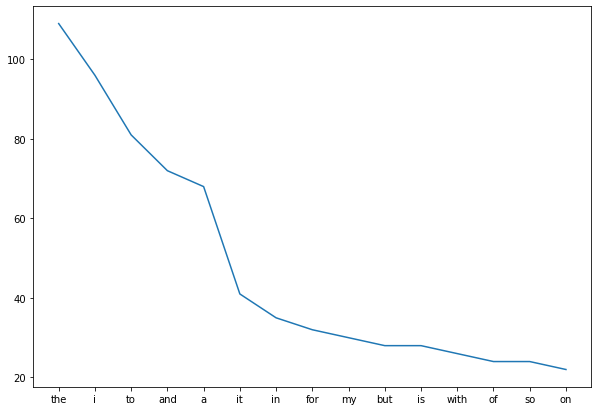

In [14]:
plt.figure(figsize=(10,7))
plt.plot(word_pd[word_pd['subreddit']=='DunkinDonuts']['tokenized_words'].value_counts()[:15])

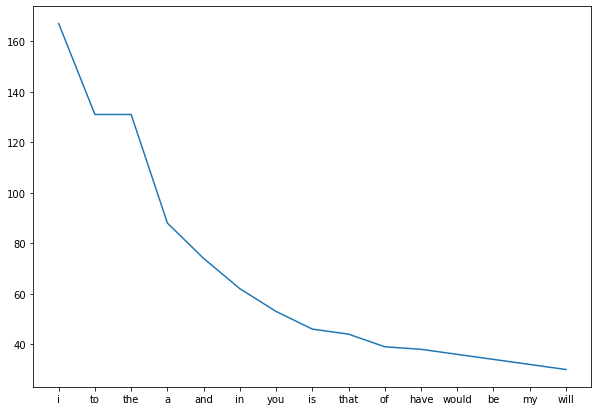

In [15]:
plt.figure(figsize=(10,7))
plt.plot(word_pd[word_pd['subreddit']=='starbucks']['tokenized_words'].value_counts()[:15])

As expected lots of stop words, not very informative. Let's remove them and re-count

### `Removing stop words`

In [16]:
df_concat['no_stopwords_selftext'] ='' #new column to store non stop-words

In [17]:
df_concat.head()

,subreddit,selftext,title,no_stopwords_selftext
0,DunkinDonuts,pumpkin small: $1.99\n\noriginal small: $2.29\...,how come the pumpkin coffee is less expensive ...,
1,DunkinDonuts,a few weeks ago someone posted a comment about...,dunkin app zip code issue,
2,DunkinDonuts,"our nearest dunkin is a bit of a drive, and th...",can you buy the unsweetened flavors dunkin uses?,
3,DunkinDonuts,how do i ask for an extra shot of flavor in th...,mobile app ordering question,
4,DunkinDonuts,i’ve used a can of monster and a variable amou...,monster energy punch at home,


In [18]:
stop_words = stopwords.words("english") # we need to add dunkin, starbucks etc.

In [19]:
new_stopwords = ["dunkin", "Dunkin", "DunkinDonuts", "donuts", "starbucks", "Starbucks","sbucks","Sbucks"] 
# adding these as stop word to remove bias in the classification 

In [20]:
stop_words.extend(new_stopwords) # appending these to the nltk list

In [21]:
#quick check on the list
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [22]:
#Using comprehension and apply to populate the new dimension without stop words
df_concat['no_stopwords_selftext'] = df_concat['selftext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [23]:
df_concat["unigrams_no_stopwords"] = df_concat["no_stopwords_selftext"].apply(nltk.word_tokenize)

In [24]:
df_concat.head()

,subreddit,selftext,title,no_stopwords_selftext,unigrams_no_stopwords
0,DunkinDonuts,pumpkin small: $1.99\n\noriginal small: $2.29\...,how come the pumpkin coffee is less expensive ...,pumpkin small: $1.99 original small: $2.29 pum...,"[pumpkin, small, :, $, 1.99, original, small, ..."
1,DunkinDonuts,a few weeks ago someone posted a comment about...,dunkin app zip code issue,weeks ago someone posted comment changing zip ...,"[weeks, ago, someone, posted, comment, changin..."
2,DunkinDonuts,"our nearest dunkin is a bit of a drive, and th...",can you buy the unsweetened flavors dunkin uses?,"nearest bit drive, flavorings available buy st...","[nearest, bit, drive, ,, flavorings, available..."
3,DunkinDonuts,how do i ask for an extra shot of flavor in th...,mobile app ordering question,ask extra shot flavor mobile app? get medium c...,"[ask, extra, shot, flavor, mobile, app, ?, get..."
4,DunkinDonuts,i’ve used a can of monster and a variable amou...,monster energy punch at home,i’ve used monster variable amount ice zero sug...,"[i, ’, ve, used, monster, variable, amount, ic..."


In [25]:
#creating a new df to run the charts on
word_pd_no_stop=pd.DataFrame(all_words(df_concat,field='no_stopwords_selftext')) # applyting function on this new field

In [26]:
word_pd_no_stop.rename(columns={0: 'subreddit',1: 'tokenized_words'},inplace=True)
word_pd_no_stop.head()

,subreddit,tokenized_words
0,DunkinDonuts,pumpkin
1,DunkinDonuts,small:
2,DunkinDonuts,$1.99
3,DunkinDonuts,original
4,DunkinDonuts,small:


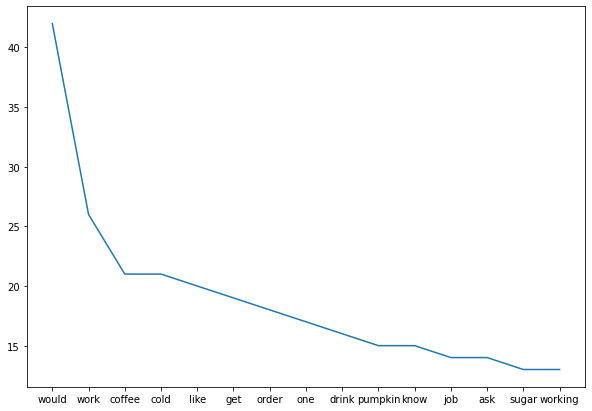

In [27]:
plt.figure(figsize=(10,7))
plt.plot(word_pd_no_stop[word_pd_no_stop['subreddit']=='DunkinDonuts']['tokenized_words'].value_counts()[:15])

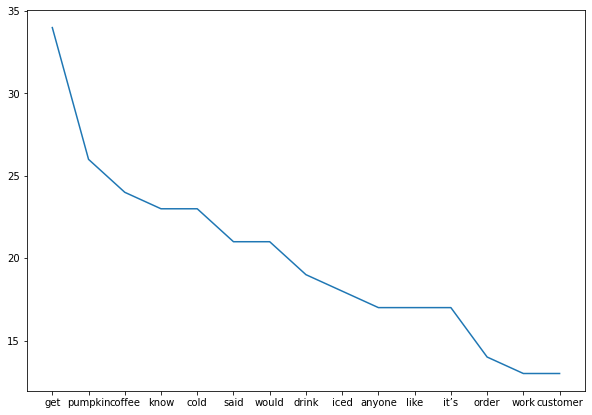

In [28]:
plt.figure(figsize=(10,7))
plt.plot(word_pd_no_stop[word_pd_no_stop['subreddit']=='starbucks']['tokenized_words'].value_counts()[:15])

though words like "coffee" came back on top in both subreddits, words like pumpkin, order, iced, appear with different frequency and will be a good test for our model to showcase its skills

In [29]:
word_pd_no_stop.groupby(['subreddit']).value_counts().sort_values(ascending=False).head(10)

subreddit     tokenized_words
DunkinDonuts  would              42
starbucks     get                34
DunkinDonuts  work               26
starbucks     pumpkin            26
              coffee             24
              cold               23
              know               23
DunkinDonuts  cold               21
starbucks     said               21
              would              21
dtype: int64

Words seem different but it is very manual

In this NLP project, we have to make several decisions:
1. how to cleanse  words (either lemmatize or stem)
2. then keep unigrams, bi-grams or tri-grams to maintain meaning?
3. how to create vectors of words ( countvec, tf-idf) 

### `Let's explore lemmatizing + CVEC on our original dataset`

**Joel shared this snippets of codes below**


#### Lemmatizing<br>
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word. 

In [30]:
# instantiate the lemmatizier and tokenizer
# retain only word characters
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

# set up the lemmatizer
lemmatized_posts = []
for post in df_concat['selftext']:
    tokens = tokenizer.tokenize(post)
    post = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts.append(' '.join(post))
    
# append the lemmatized posts to the DataFrame
df_concat['selftext_lemmatized'] = lemmatized_posts

In [31]:
# remove all numerical values
df_concat['selftext_lemmatized'].replace('\d+', '', regex=True, inplace=True)

In [32]:
# remove URLs
df_concat['selftext_lemmatized'].str.replace('http\S+','')

C:\Users\galvi\AppData\Local\Temp\ipykernel_3508\1855462287.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_concat['selftext_lemmatized'].str.replace('http\S+','')


0       pumpkin small   original small   pumpkin mediu...
1       a few week ago someone posted a comment about ...
2       our nearest dunkin is a bit of a drive and the...
3       how do i ask for an extra shot of flavor in th...
4       i ve used a can of monster and a variable amou...
                              ...                        
5796    story time of a customer i had today immediate...
5797    so i currently work at a target starbucks and ...
5798    so yesterday one of our lovely customer decide...
5799    a guy who wa clearly on drug decided it would ...
5800    hi my name s michael and recently i went to st...
Name: selftext_lemmatized, Length: 5801, dtype: object

In [33]:
# instantiate CountVectorizer (one-word, with stop words removed, and adding our list+coffee)
cvec = CountVectorizer(stop_words='english')
new_stopwords = ["dunkin", "Dunkin", "DunkinDonuts", "donuts", "starbucks", "Starbucks","sbucks","Sbucks"] 
model_stopwords = stopwords.words('english')
model_stopwords.extend(new_stopwords)

In [34]:
#reassigning the stop words list to cvec
cvec = CountVectorizer(stop_words=model_stopwords)

In [35]:
# Dunkin - fit/transform the CountVectorizer to the title and obtain the top 25 words with the highest count
dunkin_cvec = cvec.fit_transform(df_concat[df_concat['subreddit']=="DunkinDonuts"]['selftext_lemmatized'])
print('Features after removing stop words Dunkin: {}'.format(len(cvec.get_feature_names())))
dunkin_cvec = pd.DataFrame(dunkin_cvec.toarray(), 
                            columns = cvec.get_feature_names())
dunkin_lemmatized = dunkin_cvec.sum().sort_values(ascending=False).head(20)

# Starbucks
starbucks_cvec = cvec.fit_transform(df_concat[df_concat['subreddit']=="starbucks"]['selftext_lemmatized'])
print('Features after removing stop words Starbucks: {}'.format(len(cvec.get_feature_names())))
starbucks_cvec = pd.DataFrame(starbucks_cvec.toarray(), 
                            columns = cvec.get_feature_names())
starbucks_lemmatized = starbucks_cvec.sum().sort_values(ascending=False).head(20)

c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(
c:\Users\galvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Features after removing stop words Dunkin: 7091
Features after removing stop words Starbucks: 9391


c:\Users\galvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
#checking the outcome

print(type(dunkin_lemmatized))
dunkin_lemmatized.head()

<class 'pandas.core.series.Series'>


wa        1791
coffee    1407
like      1337
get       1220
order     1064
dtype: int64

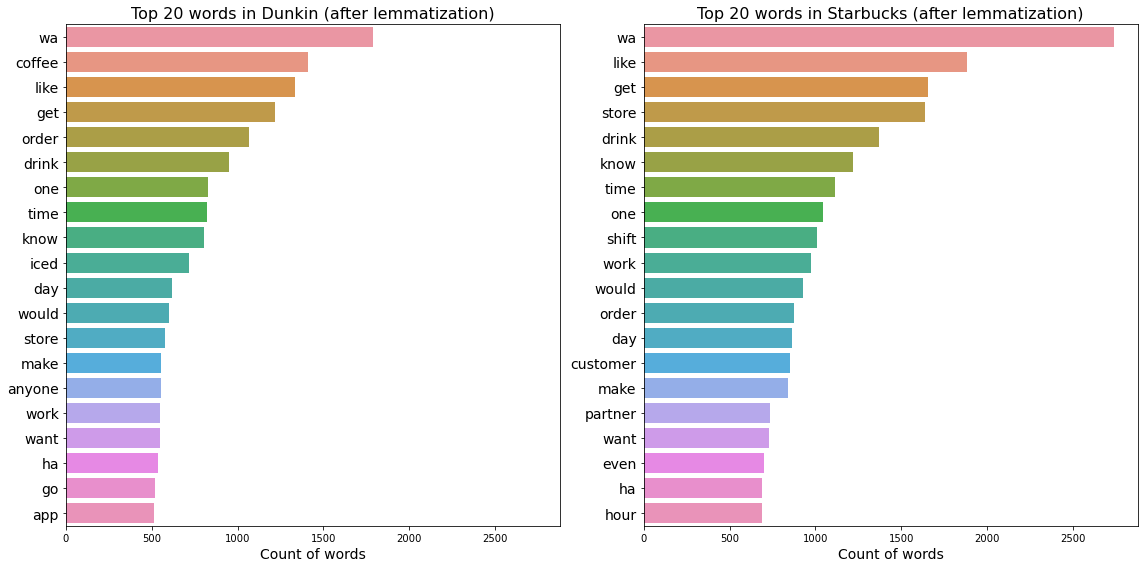

In [37]:
# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True)

# plot results for Dunkin
sns.barplot(y=dunkin_lemmatized.index.values, x=dunkin_lemmatized, ax=ax[0])
ax[0].set_title('Top 20 words in Dunkin (after lemmatization)',fontsize=16)
ax[0].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

# plot results for Starbucks
sns.barplot(y=starbucks_lemmatized.index.values, x=starbucks_lemmatized, ax=ax[1])
ax[1].set_title('Top 20 words in Starbucks (after lemmatization)',fontsize=16)
ax[1].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

WordCloud version

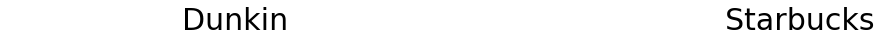

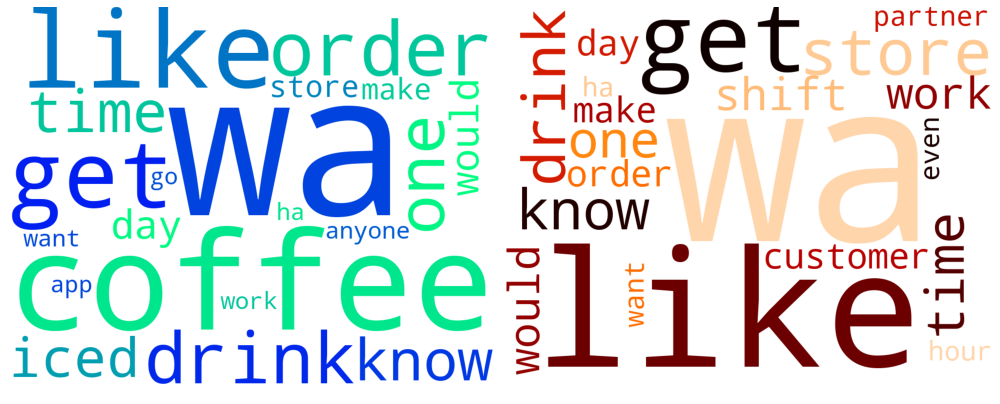

In [38]:
# set up WordCloud
wc_dunkin = WordCloud(max_words=50, width=1000, height=800, background_color='white',
                       colormap='winter').generate_from_frequencies(dunkin_lemmatized) 

wc_starbucks = WordCloud(max_words=50, width=1000, height=800, background_color ='white',
                      colormap='gist_heat').generate_from_frequencies(starbucks_lemmatized) 

plt.figure(figsize=(8,0.3))
plt.text(x=0.35,                              
         y=0.9,                             
         s='  Dunkin                                              Starbucks', 
         ha='left',                        
         va='center',                       
         size=30)                         
plt.axis('off')

# plot the WordCloud image 
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax[0].imshow(wc_dunkin)
ax[0].axis('off')
ax[1].imshow(wc_starbucks)
ax[1].axis('off')
plt.tight_layout()


### `Let's look at Lemmatizing with TF-IDF `

We will explore unigrams and bi-grams

In [39]:
tvec = TfidfVectorizer(stop_words=model_stopwords) # instantiating object, default ngrams =(1,1) = unigrams

In [40]:
#Updating with tvec object instead

#Dunkin
dunkin_tvec = tvec.fit_transform(df_concat[df_concat['subreddit']=="DunkinDonuts"]['selftext_lemmatized'])
print('Features after removing stop words Dunkin: {}'.format(len(tvec.get_feature_names())))
dunkin_tvec = pd.DataFrame(dunkin_tvec.toarray(), 
                            columns = tvec.get_feature_names())
dunkin_lemmatized_tvec = dunkin_tvec.sum().sort_values(ascending=False).head(20)

# Starbucks
starbucks_tvec = tvec.fit_transform(df_concat[df_concat['subreddit']=="starbucks"]['selftext_lemmatized'])
print('Features after removing stop words Starbucks: {}'.format(len(tvec.get_feature_names())))
starbucks_tvec = pd.DataFrame(starbucks_tvec.toarray(), 
                            columns = tvec.get_feature_names())
starbucks_lemmatized_tvec = starbucks_tvec.sum().sort_values(ascending=False).head(20)

c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(
c:\Users\galvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Features after removing stop words Dunkin: 7091
Features after removing stop words Starbucks: 9391


c:\Users\galvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


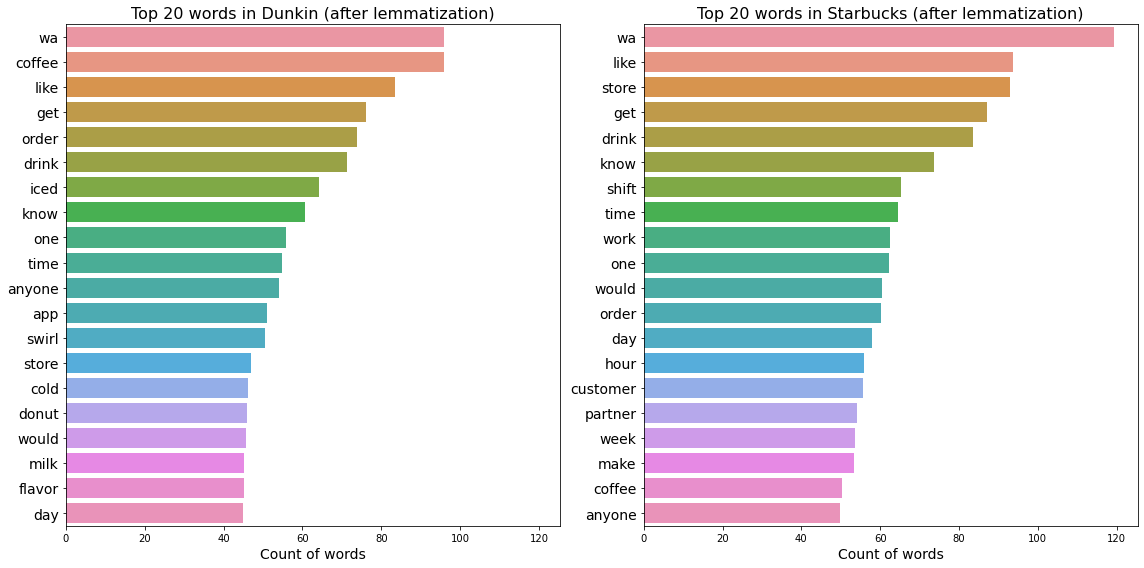

In [41]:
# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True)

# plot results for Dunkin
sns.barplot(y=dunkin_lemmatized_tvec.index.values, x=dunkin_lemmatized_tvec, ax=ax[0])
ax[0].set_title('Top 20 words in Dunkin (after lemmatization)',fontsize=16)
ax[0].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

# plot results for Starbucks
sns.barplot(y=starbucks_lemmatized_tvec.index.values, x=starbucks_lemmatized_tvec, ax=ax[1])
ax[1].set_title('Top 20 words in Starbucks (after lemmatization)',fontsize=16)
ax[1].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

It is stricking to see that **starbucks words weem more professional-related**, with Hours, shift, time work, day....<br>
**Dunkin seems to be more product-focused**, but with some top words in common: like, get, drink.<br>
it's a good mix so it's not too easy for the model to guess where the posts are from

**We can't really see a difference between TF-IDF and Countvectorizer**

### `Let's redo this setting the n-gram parameter to 2`

In [42]:
#Updating with tvec object instead
tvec=TfidfVectorizer(ngram_range=(2,2),stop_words=model_stopwords) #For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams. Only applies if analyzer is not callable.

#Dunkin
dunkin_tvec = tvec.fit_transform(df_concat[df_concat['subreddit']=="DunkinDonuts"]['selftext_lemmatized'])
print('Features after removing stop words Dunkin: {}'.format(len(tvec.get_feature_names())))
dunkin_tvec = pd.DataFrame(dunkin_tvec.toarray(), 
                            columns = tvec.get_feature_names())
dunkin_lemmatized_tvec = dunkin_tvec.sum().sort_values(ascending=False).head(20)

# Starbucks
starbucks_tvec = tvec.fit_transform(df_concat[df_concat['subreddit']=="starbucks"]['selftext_lemmatized'])
print('Features after removing stop words Starbucks: {}'.format(len(tvec.get_feature_names())))
starbucks_tvec = pd.DataFrame(starbucks_tvec.toarray(), 
                            columns = tvec.get_feature_names())
starbucks_lemmatized_tvec = starbucks_tvec.sum().sort_values(ascending=False).head(20)

c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(
c:\Users\galvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Features after removing stop words Dunkin: 70537


c:\Users\galvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Features after removing stop words Starbucks: 102695


**We get way more features as a result of combining words together**

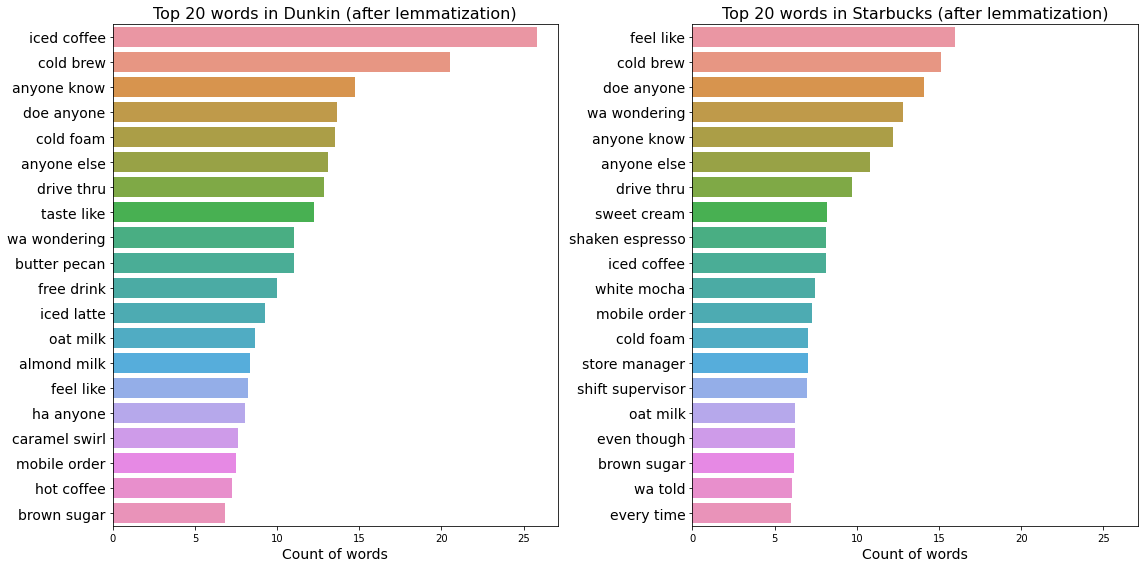

In [44]:
# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=True)

# plot results for Dunkin
sns.barplot(y=dunkin_lemmatized_tvec.index.values, x=dunkin_lemmatized_tvec, ax=ax[0])
ax[0].set_title('Top 20 words in Dunkin (after lemmatization)',fontsize=16)
ax[0].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

# plot results for Starbucks
sns.barplot(y=starbucks_lemmatized_tvec.index.values, x=starbucks_lemmatized_tvec, ax=ax[1])
ax[1].set_title('Top 20 words in Starbucks (after lemmatization)',fontsize=16)
ax[1].set_xlabel('Count of words', fontsize=14)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

**The bigrams ranking now widely differs. Not sure if it is a good thing for our model**

### `Checking distribution of posts length`

In [45]:
#checking the distribution of posts length
df_concat['len_posts']=df_concat['selftext'].str.len()

In [46]:
df_concat.head()

,subreddit,selftext,title,no_stopwords_selftext,unigrams_no_stopwords,selftext_lemmatized,len_posts
0,DunkinDonuts,pumpkin small: $1.99\n\noriginal small: $2.29\...,how come the pumpkin coffee is less expensive ...,pumpkin small: $1.99 original small: $2.29 pum...,"[pumpkin, small, :, $, 1.99, original, small, ...",pumpkin small original small pumpkin mediu...,282
1,DunkinDonuts,a few weeks ago someone posted a comment about...,dunkin app zip code issue,weeks ago someone posted comment changing zip ...,"[weeks, ago, someone, posted, comment, changin...",a few week ago someone posted a comment about ...,622
2,DunkinDonuts,"our nearest dunkin is a bit of a drive, and th...",can you buy the unsweetened flavors dunkin uses?,"nearest bit drive, flavorings available buy st...","[nearest, bit, drive, ,, flavorings, available...",our nearest dunkin is a bit of a drive and the...,212
3,DunkinDonuts,how do i ask for an extra shot of flavor in th...,mobile app ordering question,ask extra shot flavor mobile app? get medium c...,"[ask, extra, shot, flavor, mobile, app, ?, get...",how do i ask for an extra shot of flavor in th...,379
4,DunkinDonuts,i’ve used a can of monster and a variable amou...,monster energy punch at home,i’ve used monster variable amount ice zero sug...,"[i, ’, ve, used, monster, variable, amount, ic...",i ve used a can of monster and a variable amou...,134


Plotting

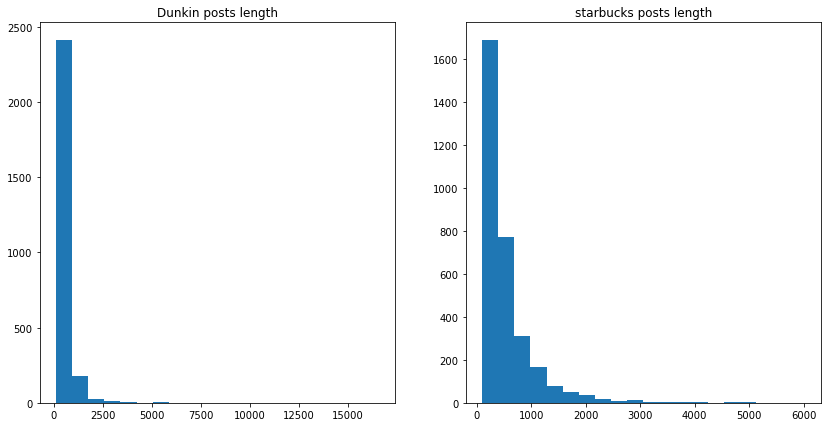

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].hist(df_concat[df_concat['subreddit']=='DunkinDonuts']['len_posts'],bins=20)
axes[0].set_title('Dunkin posts length')
axes[1].hist(df_concat[df_concat['subreddit']=='starbucks']['len_posts'],bins=20)
axes[1].set_title('starbucks posts length');

<AxesSubplot:xlabel='subreddit', ylabel='len_posts'>

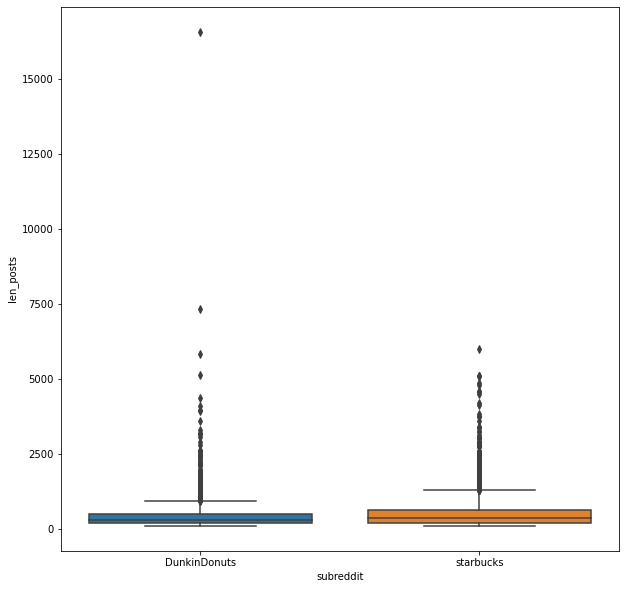

In [48]:
plt.figure(figsize=(10,10))
sns.boxplot(data = df_concat, x='subreddit',y="len_posts")# a couple of outliers here, we will explore next

Let's quickly explore what the 15000 dunkin words really says 

In [49]:
df_concat[df_concat['len_posts']>10000].values

array([['DunkinDonuts',
        "i have an interview with dunkin donuts in a few days. the job is a crew member. my responsibilities will include but will not be limited to thoroughly cleaning tables, obeying safety and sanitation guidelines, handling cash register transactions and pouring coffee. \n\ni have done research to find out what types of questions i can expect to receive during the interview. below is a list of possible questions and the answers i have drafted. i will gladly accept any feedback. it is doubtful that every single one of these questions would be asked, but some of them will and i don’t know which ones will and which ones won’t be asked, so i need to be prepared. please focus not on how likely it is that i will be asked these questions, but on whether or not the answers i have drafted would make sense had these questions been asked. \n\n**what are your strengths**?\n\ni am a quick learner. i am enthusiastic and hungry to learn. furthermore, i take criticism reall

Thats actually quite informative. We will keep all lengthy outliers as these may contain good information to train the model

In [50]:
df_concat.to_csv('transformed_csv\df_concat_part2.csv') # exporting the consolidated file

### `Decision on models to evaluate`

In the next notebook, we will model using our learnings from the EDA:<br>
1. We must remove stop words, and customize the list
2. TF-IDF vs CountVectorizer: we need to evaluate both transformers as we can't see much difference here
3. Working on selftext provide the model with more details than title